In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib  
from scipy import stats
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 설정


In [2]:
df_final = pd.read_csv("..\data\df_final.csv",encoding='utf-8')

In [21]:
facility_df=pd.read_csv("..\data\서울시_지하철_역사_노약자_장애인_편의시설_현황.csv",encoding='cp949')

In [3]:
df_copied = df_final.copy()

df_copied['날짜'] = pd.to_datetime(df_copied['날짜'].astype(str), format='%Y%m%d')
df_copied['요일'] = df_copied['날짜'].dt.dayofweek

# 총 승객(일반 승객 + 노인 승객) <-- 전처리 시 반영되었다면 삭제 가능 
df_copied['전체 승객'] = df_copied['general'] + df_copied['old']

In [4]:
holidays_dt = pd.to_datetime([              # 공휴일 리스트 날짜 데이터로 변환
    '2024-01-01', # 신정
    '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', # 설날 연휴 및 대체공휴일
    '2024-03-01', # 삼일절
    '2024-04-10', # 제22대 국회의원 선거일
    '2024-05-05', '2024-05-06', # 어린이날 및 대체공휴일
    '2024-05-15', # 부처님 오신 날
    '2024-06-06', # 현충일
    '2024-08-15', # 광복절
    '2024-09-16', '2024-09-17', '2024-09-18', # 추석 연휴
    '2024-10-03', # 개천절
    '2024-10-09', # 한글날
    '2024-12-25' # 성탄절
])

df_weekday = df_copied[    
    (df_copied['요일'] < 5) &    # 평일 
    (~df_copied['날짜'].isin(holidays_dt))  # not 공휴일
].copy()

# 결과 확인

print(f"필터링 전 데이터: {len(df_copied)}행")
print(f"필터링 후 평일 데이터: {len(df_weekday)}행")
display(df_weekday.head())

필터링 전 데이터: 3868440행
필터링 후 평일 데이터: 2610600행


,날짜,호선,역번호,역명,구분,시간대,general,old,요일,전체 승객
2,2024-01-02,1호선,150,서울역,승차,5.0,219,76,1,295
3,2024-01-02,1호선,150,서울역,하차,5.0,240,78,1,318
4,2024-01-03,1호선,150,서울역,승차,5.0,235,77,2,312
5,2024-01-03,1호선,150,서울역,하차,5.0,198,81,2,279
6,2024-01-04,1호선,150,서울역,승차,5.0,244,76,3,320


In [5]:
rush_hours = [7.0, 8.0] # 출근시간대 설정

# 역별 출근 시간대 합계
df_rush = df_weekday[df_weekday['시간대'].isin(rush_hours)].groupby('역명')[['general','old']].sum().reset_index()
df_rush.columns = ['역명', 'gen_rush_count', 'old_rush_count']

# 역별 전체 시간대 합계
df_total = df_weekday.groupby('역명')[['general', 'old']].sum().reset_index()
df_total.columns = ['역명', 'gen_total', 'old_total']

# 2. 데이터 병합 및 비중(%) 계산
rush_final = pd.merge(df_rush, df_total, on='역명')
rush_final['gen_ratio'] = (rush_final['gen_rush_count'] / rush_final['gen_total']) * 100
rush_final['old_ratio'] = (rush_final['old_rush_count'] / rush_final['old_total']) * 100

# 3.t-검정 수행 (equal_var=False: 웰치 t-검정)
t_stat, p_val = stats.ttest_ind(rush_final['gen_ratio'], rush_final['old_ratio'], equal_var=False)

# 4. 결과 출력
print("--- [가설 1] 출근 시간대 이용 패턴 비교 요약 ---")
print(f"1. 절대적 이용 인원수(평균): 일반 {rush_final['gen_rush_count'].mean():.1f}명 vs 노인 {rush_final['old_rush_count'].mean():.1f}명")
print(f"2. 집단 내 이용 비중(평균): 일반 {rush_final['gen_ratio'].mean():.2f}% vs 노인 {rush_final['old_ratio'].mean():.2f}%")
print(f"3. 통계적 유의성(p-value): {p_val:.4e}")


--- [가설 1] 출근 시간대 이용 패턴 비교 요약 ---
1. 절대적 이용 인원수(평균): 일반 1742126.2명 vs 노인 136287.3명
2. 집단 내 이용 비중(평균): 일반 21.21% vs 노인 10.29%
3. 통계적 유의성(p-value): 6.7923e-117


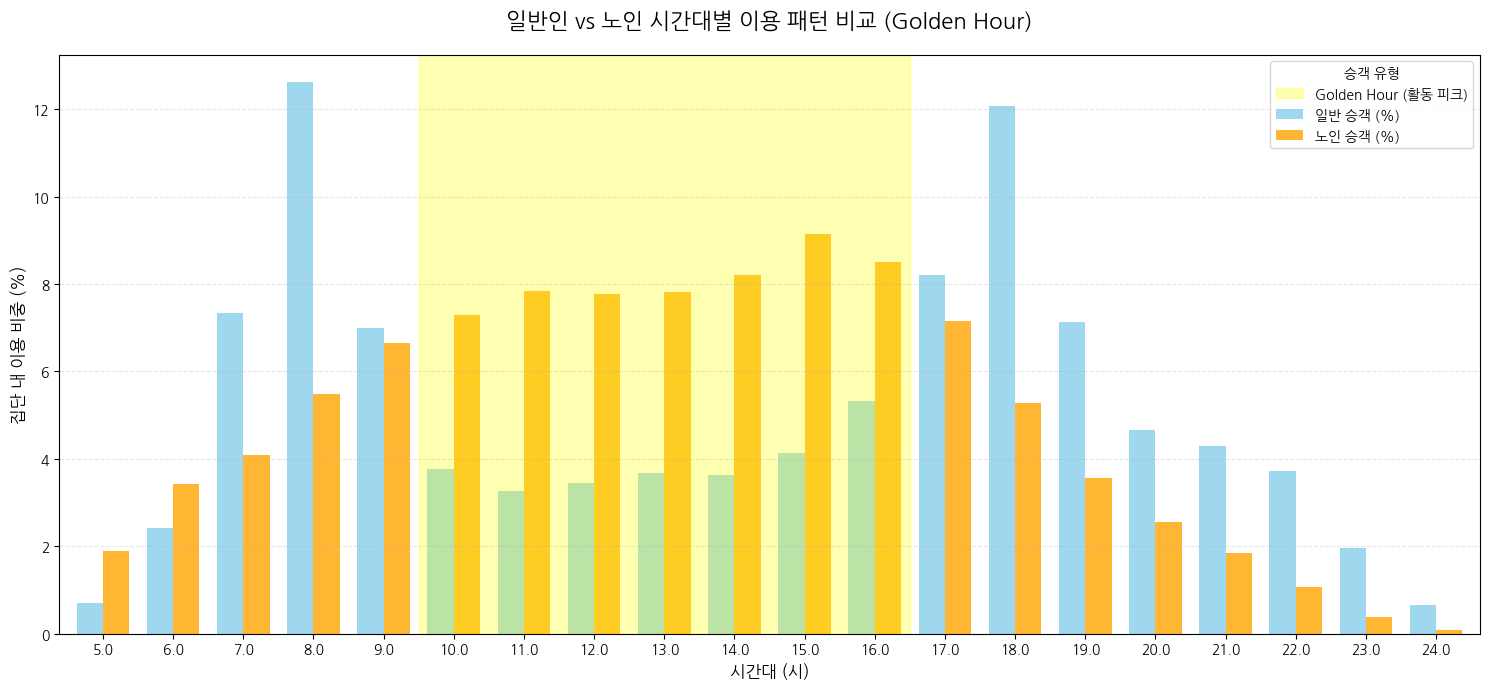

In [6]:
# Golden Hour 분석: 10시~16시 노인 이용 비중 산출

# 시간대별 인원 합계 계산
df_weekday = df_weekday.groupby('시간대')[['old', 'general']].sum().reset_index()

# 비율(%) 계산: 각 시간대 인원 / 전체 인원 * 100
df_weekday['노인비율'] = (df_weekday['old'] / df_weekday['old'].sum()) * 100
df_weekday['일반비율'] = (df_weekday['general'] / df_weekday['general'].sum()) * 100

# 시간대를 인덱스로 설정
plot_df = df_weekday.set_index('시간대')[['일반비율', '노인비율']]
plot_df.columns = ['일반 승객 (%)', '노인 승객 (%)']

# kind='bar'-->컬럼 한 프레임 내로 설정
ax = plot_df.plot(kind = 'bar', figsize=(15, 7), 
                  color = ['skyblue', 'orange'], 
                  width = 0.75, # 막대 너비 조절
                  alpha = 0.8,
                  rot = 0 ) # X축 글자 회전 방지

# Golden Hour (10시 ~ 16시) 강조 영역 설정
plt.axvspan(4.5, 11.5, color = 'yellow', alpha = 0.3, label = 'Golden Hour (활동 피크)')

# 4. 그래프 꾸미기
plt.title('일반인 vs 노인 시간대별 이용 패턴 비교 (Golden Hour)', fontsize = 16, pad = 20)
plt.xlabel('시간대 (시)', fontsize = 12)
plt.ylabel('집단 내 이용 비중 (%)', fontsize = 12)
plt.legend(title = '승객 유형', loc = 'upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 가설 2

In [7]:
df_general = df_final.drop(columns=['old']).copy()
df_senior = df_final.drop(columns=['general']).copy()

In [8]:
# 역명 전처리
df_senior['역명'] = df_senior['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()
df_general['역명'] = df_general['역명'].str.replace(r'\(.*\)', '', regex=True).str.strip()

In [9]:
# 평일/주말 구분
df_senior['날짜'] = pd.to_datetime(df_senior['날짜'],format='%Y%m%d')
df_general['날짜'] = pd.to_datetime(df_general['날짜'], format='%Y%m%d')

df_senior['요일'] = df_senior['날짜'].dt.weekday
df_general['요일'] = df_general['날짜'].dt.weekday

df_senior['주말여부'] = df_senior['요일'].apply(lambda x: '주말' if x >= 5 else '평일')
df_general['주말여부'] = df_general['요일'].apply(lambda x: '주말' if x >= 5 else '평일')

# 공휴일 처리
holidays = ['2024-01-01', # 신정
    '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', # 설날 연휴 및 대체공휴일
    '2024-03-01', # 삼일절
    '2024-04-10', # 제22대 국회의원 선거일
    '2024-05-05', '2024-05-06', # 어린이날 및 대체공휴일
    '2024-05-15', # 부처님 오신 날
    '2024-06-06', # 현충일
    '2024-08-15', # 광복절
    '2024-09-16', '2024-09-17', '2024-09-18', # 추석 연휴
    '2024-10-01', # 국군의 날 (임시공휴일 지정됨)
    '2024-10-03', # 개천절
    '2024-10-09', # 한글날
    '2024-12-25'] # 성탄절
df_senior.loc[df_senior['날짜'].isin(pd.to_datetime(holidays)), '주말여부'] = '주말'
df_general.loc[df_general['날짜'].isin(pd.to_datetime(holidays)), '주말여부'] = '주말'


# 평일 데이터 추출
df_senior_weekday = df_senior[df_senior['주말여부'] == '평일'].copy()
df_general_weekday = df_general[df_general['주말여부'] == '평일'].copy()

# 주말 데이터 추출
df_senior_weekend = df_senior[df_senior['주말여부'] == '주말'].copy()
df_general_weekend = df_general[df_general['주말여부'] == '주말'].copy()

In [13]:
# 평일 10-16시 평균 하차량 계산
target_hours = [10, 11, 12, 13, 14, 15]

df_senior_off_weekday = df_senior_weekday[df_senior_weekday['구분'] == '하차'].copy()
df_general_off_weekday = df_general_weekday[df_general_weekday['구분'] == '하차'].copy()

df_senior_midday = df_senior_off_weekday[df_senior_off_weekday['시간대'].isin(target_hours)]
station_rank = df_senior_midday.groupby(['역명', '역번호'])['old'].sum() / df_senior_off_weekday['날짜'].nunique()

top_10_midday = station_rank.sort_values(ascending=False).head(10)

print(" [평일 10-16시 노인 평균 하차량 기준 TOP 10] ")
print(top_10_midday.round(2))

top_10_stations = top_10_midday.index.get_level_values('역명').unique().tolist()

 [평일 10-16시 노인 평균 하차량 기준 TOP 10] 
역명     역번호
제기동    157    5839.95
청량리    158    5340.09
종로3가   153    5265.30
종로5가   154    4766.78
회현     425    4679.44
고속터미널  329    4038.76
선릉     220    3946.41
연신내    311    3683.45
창동     412    3443.96
잠실     216    3349.41
Name: old, dtype: float64


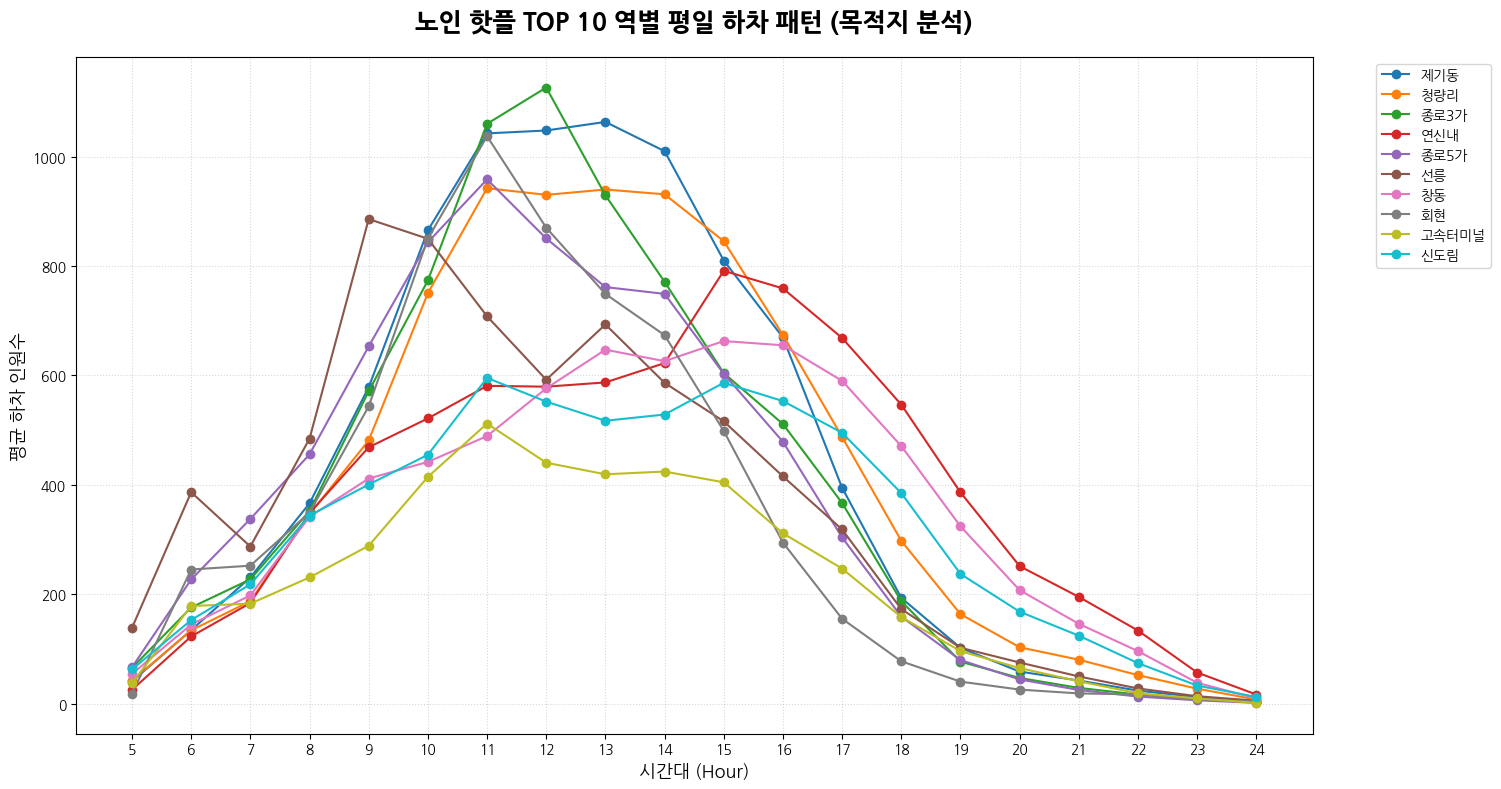

In [14]:
# TOP 10 역들의 시간대별 하차 패턴 시각화
import koreanize_matplotlib
top_10_weekday_name = top_10_weekday.index.get_level_values('역명').unique().tolist()

plt.figure(figsize=(15, 8))
for station in top_10_weekday_name:
    station_data = df_senior_off_weekday[df_senior_off_weekday['역명'] == station]
    hourly_pattern = station_data.groupby('시간대')['old'].mean()
    plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o', label=station)

plt.title('노인 핫플 TOP 10 역별 평일 하차 패턴 (목적지 분석)', fontsize=18, pad=20, fontweight='bold')
plt.xlabel('시간대 (Hour)', fontsize=13)
plt.ylabel('평균 하차 인원수', fontsize=13)
plt.xticks(range(5, 25))

plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()

plt.show()

C:\Users\jinuk\AppData\Local\Temp\ipykernel_20744\78955925.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ttest_final, x='역명', y='t_stat', palette='coolwarm')


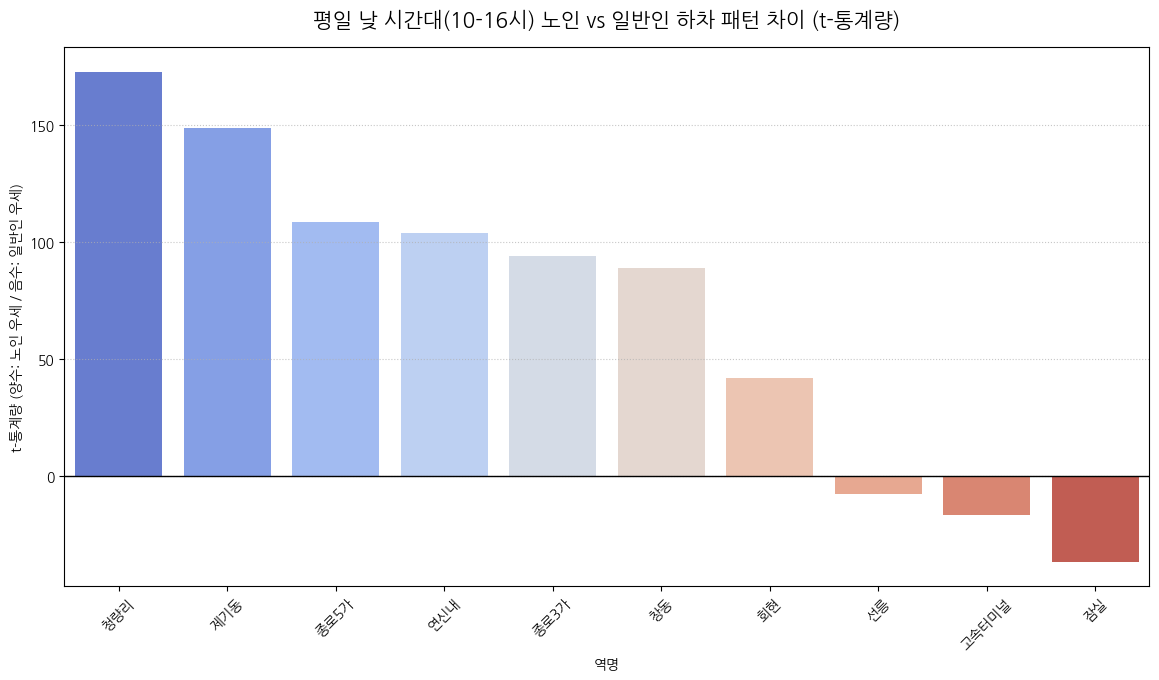

      역명  노인_낮비중  일반_낮비중    t_stat  p_value
1    청량리  0.0011  0.0003  172.7182      0.0
0    제기동  0.0012  0.0002  148.7022      0.0
3   종로5가  0.0010  0.0004  108.4025      0.0
7    연신내  0.0008  0.0003  104.0009      0.0
2   종로3가  0.0011  0.0004   93.8867      0.0
8     창동  0.0007  0.0004   88.9603      0.0
4     회현  0.0010  0.0006   41.7466      0.0
6     선릉  0.0008  0.0009   -7.6831      0.0
5  고속터미널  0.0005  0.0007  -16.6321      0.0
9     잠실  0.0005  0.0009  -36.6984      0.0


In [15]:
# 비중 기준 t검정
from scipy import stats

s_day_total = df_senior_off_weekday[
    (df_senior_off_weekday['시간대'].isin(target_hours))
]['old'].sum()

g_day_total = df_general_off_weekday[
    (df_general_off_weekday['시간대'].isin(target_hours))
]['general'].sum()

ttest_results = []

for station in top_10_stations:
    s_target = df_senior_off_weekday[
        (df_senior_off_weekday['역명'] == station) &
        (df_senior_off_weekday['시간대'].isin(target_hours))
    ]['old']

    g_target = df_general_off_weekday[
        (df_general_off_weekday['역명'] == station) &
        (df_general_off_weekday['시간대'].isin(target_hours))
    ]['general']

    s_ratio = s_target / s_day_total
    g_ratio = g_target / g_day_total

    t_stat, p_val = stats.ttest_ind(s_ratio, g_ratio, equal_var=False)

    ttest_results.append({
        '역명': station,
        '노인_낮비중': s_ratio.mean() * 100, # 백분율 %
        '일반_낮비중': g_ratio.mean() * 100, # 백분율 %
        't_stat': t_stat,
        'p_value': p_val
    })

df_ttest_final = pd.DataFrame(ttest_results).sort_values(by='t_stat', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(data=df_ttest_final, x='역명', y='t_stat', palette='coolwarm')
plt.axhline(0, color='black', linewidth=1)

plt.title('평일 낮 시간대(10-16시) 노인 vs 일반인 하차 패턴 차이 (t-통계량)', fontsize=15, pad=15)
plt.ylabel('t-통계량 (양수: 노인 우세 / 음수: 일반인 우세)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()

print(df_ttest_final.round(4))

In [40]:
df_copied = df_final.copy()

df_copied['날짜'] = pd.to_datetime(df_copied['날짜'].astype(str), format='%Y%m%d')
df_copied['요일'] = df_copied['날짜'].dt.dayofweek

# 총 승객(일반 승객 + 노인 승객) <-- 전처리 시 반영되었다면 삭제 가능 
df_copied['전체 승객'] = df_copied['general'] + df_copied['old']
# 평일만(공휴일/주말 제외)

df_weekday = df_copied[    
    (df_copied['요일'] < 5) &    # 평일 
    (~df_copied['날짜'].isin(holidays_dt))  # not 공휴일
].copy()
df_weekday['역명'] = (
    df_weekday['역명']
    .str.replace(r'\(.*?\)', '', regex=True)
    .str.strip()
)


필터링 전 데이터: 3868440행
필터링 후 평일 데이터: 2610600행


,날짜,호선,역번호,역명,구분,시간대,general,old,요일,전체 승객
2,2024-01-02,1호선,150,서울역,승차,5.0,219,76,1,295
3,2024-01-02,1호선,150,서울역,하차,5.0,240,78,1,318
4,2024-01-03,1호선,150,서울역,승차,5.0,235,77,2,312
5,2024-01-03,1호선,150,서울역,하차,5.0,198,81,2,279
6,2024-01-04,1호선,150,서울역,승차,5.0,244,76,3,320


In [41]:
station_time_avg = (
    df_weekday
    .groupby(['호선','역명', '시간대'])
    .agg(
        old_avg=('old', 'mean'),
        general_avg=('general', 'mean')
    )
    .reset_index()
)

station_time_avg.head()


,호선,역명,시간대,old_avg,general_avg
0,1호선,동대문,5.0,74.366397,211.151822
1,1호선,동대문,6.0,85.487854,226.273279
2,1호선,동대문,7.0,112.647773,429.018219
3,1호선,동대문,8.0,165.546559,629.220648
4,1호선,동대문,9.0,213.704453,532.949393


In [34]:
idx = station_time_avg.groupby('역명')['old_avg'].idxmax()
station_peak = station_time_avg.loc[idx].reset_index(drop=True)
station_peak.head()

,호선,역명,시간대,old_avg,general_avg
0,3호선,가락시장,15.0,253.293522,293.888664
1,7호선,가산디지털단지,15.0,289.080972,1199.866397
2,2호선,강남,15.0,547.653846,3659.617409
3,7호선,강남구청,15.0,169.232794,618.568826
4,5호선,강동,15.0,300.892713,605.941296


In [35]:
facility_df['역명'] = facility_df['역명'].str.replace(r'\(.*?\)', '', regex=True)
line_map = {
    '5(연)호선': '5호선',
    '8(연)호선': '8호선'
    
}

facility_df['호선'] = facility_df['호선'].replace(line_map)


In [42]:
station_merged = station_peak.merge(
    facility_df,
    on=['호선','역명'],
    how='left'
)
station_merged=station_merged.drop(columns=['휠체어리프트(W/L)','수평자동보도(M/W)'])

In [43]:
station_merged['facility_score'] = (
    station_merged['엘리베이터(E/V)'] * 0.7 +
    station_merged['에스컬레이터(E/S)'] * 0.3
)
station_merged.info()

station_merged[station_merged['facility_score'].isna()][['호선', '역명']]


<class 'pandas.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   호선              236 non-null    str    
 1   역명              236 non-null    str    
 2   시간대             236 non-null    float64
 3   old_avg         236 non-null    float64
 4   general_avg     236 non-null    float64
 5   엘리베이터(E/V)      236 non-null    int64  
 6   에스컬레이터(E/S)     236 non-null    int64  
 7   facility_score  236 non-null    float64
dtypes: float64(4), int64(2), str(2)
memory usage: 18.5 KB


,호선,역명


In [44]:
station_merged['facility_per_old'] = (
    station_merged['facility_score'] /
    station_merged['old_avg']
)

In [45]:
station_merged['facility_norm'] = (
    station_merged['facility_score'] - station_merged['facility_score'].min()
) / (
    station_merged['facility_score'].max() - station_merged['facility_score'].min()
)

station_merged['old_norm'] = (
    station_merged['old_avg'] - station_merged['old_avg'].min()
) / (
    station_merged['old_avg'].max() - station_merged['old_avg'].min()
)

station_merged['facility_gap'] = station_merged['facility_norm'] - station_merged['old_norm']

In [47]:
station_merged_sorted = station_merged.sort_values(
    by='facility_gap',
    ascending=True
)
station_merged_sorted.head()

,호선,역명,시간대,old_avg,general_avg,엘리베이터(E/V),에스컬레이터(E/S),facility_score,facility_per_old,facility_norm,old_norm,facility_gap
196,1호선,제기동,14.0,979.216599,500.566802,3,2,2.7,0.002757,0.190476,1.000000,-0.809524
199,1호선,종로5가,14.0,849.275304,982.827935,3,0,2.1,0.002473,0.133333,0.863940,-0.730606
213,1호선,청량리,15.0,930.410931,774.133603,2,6,3.2,0.003439,0.238095,0.948896,-0.710801
198,1호선,종로3가,12.0,909.613360,854.751012,3,4,3.3,0.003628,0.247619,0.927119,-0.679500
117,2호선,선릉,15.0,834.269231,2181.878543,3,2,2.7,0.003236,0.190476,0.848227,-0.657751


In [48]:
target_stations = [
    '제기동', '청량리', '종로3가', '종로5가',
    '회현', '고속터미널', '선릉', '연신내',
    '창동', '잠실'
]
group_target = station_merged[station_merged['역명'].isin(target_stations)]['facility_gap']
group_others = station_merged[~station_merged['역명'].isin(target_stations)]['facility_gap']


In [49]:
from scipy.stats import ttest_ind

t_stat, p_two = ttest_ind(
    group_target,
    group_others,
    equal_var=False,
    nan_policy='omit'
)

# 단측 p-value (greater)
p_one = p_two / 2 if t_stat > 0 else 1 - (p_two / 2)

t_stat, p_one


(np.float64(-6.775820140834018), np.float64(0.999967239037845))

In [50]:
target_df = (
     station_merged[station_merged['역명'].isin(target_stations)]
    .dropna(subset=['facility_score'])
)
target_df

,호선,역명,시간대,old_avg,general_avg,엘리베이터(E/V),에스컬레이터(E/S),facility_score,facility_per_old,facility_norm,old_norm,facility_gap
16,3호선,고속터미널,15.0,785.246964,2806.188259,2,24,8.6,0.010952,0.752381,0.796896,-0.044515
117,2호선,선릉,15.0,834.269231,2181.878543,3,2,2.7,0.003236,0.190476,0.848227,-0.657751
163,3호선,연신내,15.0,707.753036,1085.121457,1,4,1.9,0.002685,0.114286,0.715753,-0.601467
188,2호선,잠실,15.0,671.214575,3646.552632,4,8,5.2,0.007747,0.428571,0.677494,-0.248922
196,1호선,제기동,14.0,979.216599,500.566802,3,2,2.7,0.002757,0.190476,1.000000,-0.809524
198,1호선,종로3가,12.0,909.613360,854.751012,3,4,3.3,0.003628,0.247619,0.927119,-0.679500
199,1호선,종로5가,14.0,849.275304,982.827935,3,0,2.1,0.002473,0.133333,0.863940,-0.730606
206,4호선,창동,15.0,646.629555,978.769231,8,6,7.4,0.011444,0.638095,0.651751,-0.013656
213,1호선,청량리,15.0,930.410931,774.133603,2,6,3.2,0.003439,0.238095,0.948896,-0.710801
234,4호선,회현,14.0,806.977733,1175.502024,2,6,3.2,0.003965,0.238095,0.819650,-0.581555


In [51]:
priority_df = (
    target_df
    .sort_values('facility_gap')
    .reset_index(drop=True)
)

priority_df[['호선', '역명', 'facility_score', 'facility_gap']]

,호선,역명,facility_score,facility_gap
0,1호선,제기동,2.7,-0.809524
1,1호선,종로5가,2.1,-0.730606
2,1호선,청량리,3.2,-0.710801
3,1호선,종로3가,3.3,-0.679500
4,2호선,선릉,2.7,-0.657751
5,3호선,연신내,1.9,-0.601467
6,4호선,회현,3.2,-0.581555
7,2호선,잠실,5.2,-0.248922
8,3호선,고속터미널,8.6,-0.044515
9,4호선,창동,7.4,-0.013656


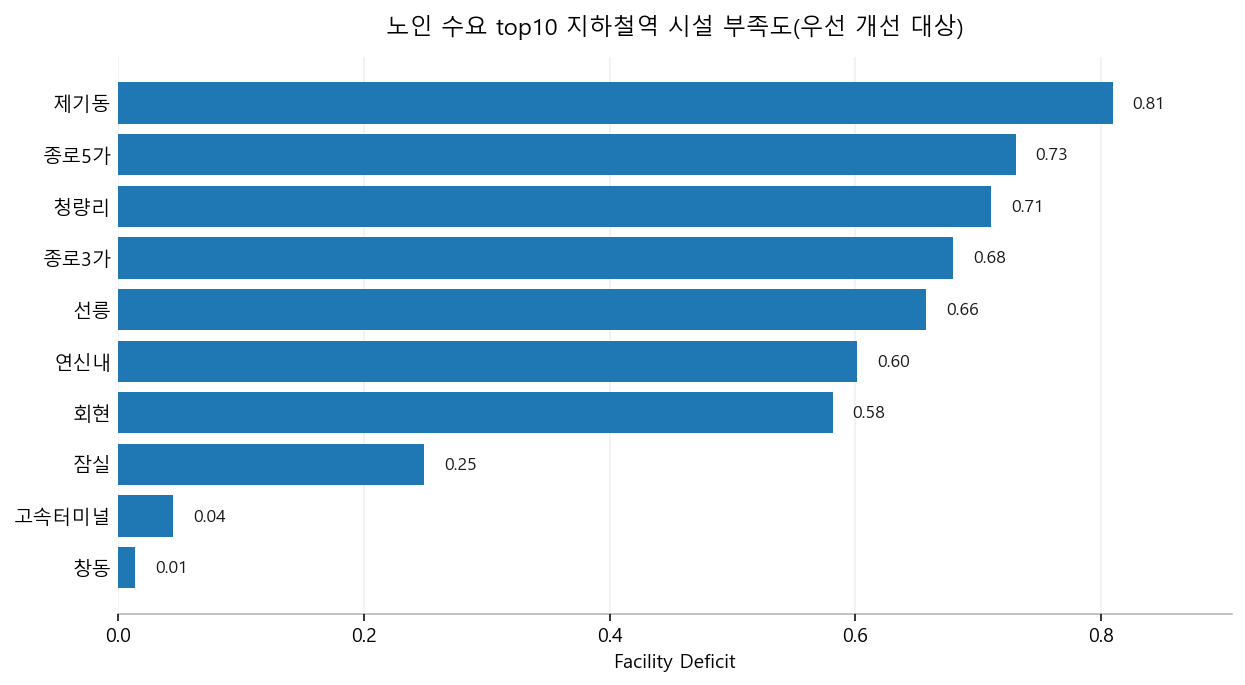

In [52]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plot_df = priority_df.copy()

# 시설 부족지수
plot_df['deficit'] = -plot_df['facility_gap']

# 정렬
plot_df = plot_df.sort_values('deficit', ascending=True)

fig, ax = plt.subplots(figsize=(9, 5), dpi=140)

bars = ax.barh(plot_df['역명'], plot_df['deficit'])

for s in ['top', 'right', 'left']:
    ax.spines[s].set_visible(False)
ax.spines['bottom'].set_alpha(0.3)

ax.grid(axis='x', alpha=0.2)
ax.set_axisbelow(True)

ax.set_title('노인 수요 top10 지하철역 시설 부족도(우선 개선 대상)', pad=12)
ax.set_xlabel('Facility Deficit')
ax.set_ylabel('')

maxv = plot_df['deficit'].max()
ax.set_xlim(0, maxv * 1.12)

for b in bars:
    v = b.get_width()
    ax.text(v + maxv*0.02, b.get_y() + b.get_height()/2,
            f"{v:.2f}", va='center', fontsize=9, alpha=0.9)

ax.tick_params(axis='y', length=0)          # y축 눈금선 제거


plt.tight_layout()
plt.show()


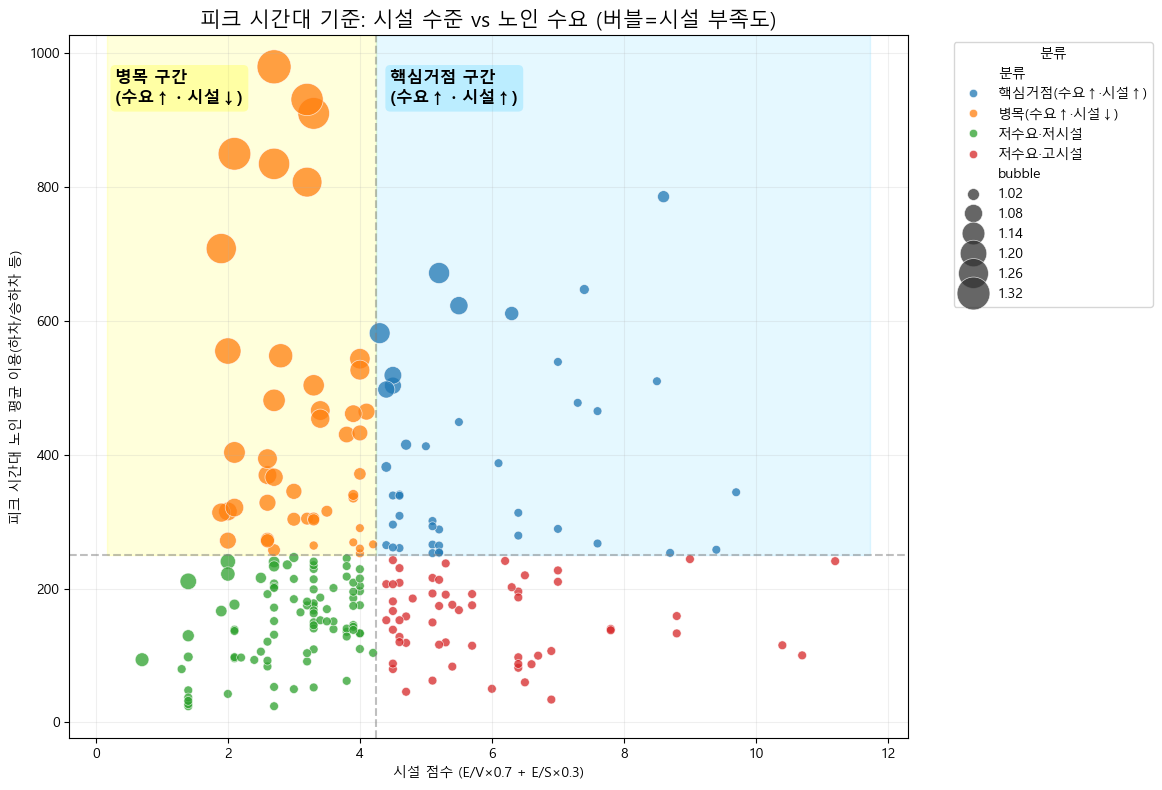

In [54]:
df_analysis = station_merged.copy()
df_analysis = df_analysis.dropna(subset=['facility_score', 'old_avg', 'facility_gap'])

# 1) 시설 부족지수(deficit): 클수록 "더 부족"
df_analysis['deficit'] = (-df_analysis['facility_gap']).clip(lower=0)

# 2) 역 단위로 집계 (역명×시간대였으면 역별 1행으로)
df_station = (
    df_analysis
    .groupby(['호선', '역명'], as_index=False)
    .agg(
        old_avg=('old_avg', 'mean'),
        facility_score=('facility_score', 'mean'),
        deficit=('deficit', 'mean')
    )
)

# 3) 평균 기준선(4분면)
fac_mean = df_station['facility_score'].mean()
old_mean = df_station['old_avg'].mean()

# 4) 분류 라벨 (요청: 왼쪽 위=병목, 오른쪽 위=핵심거점)
def classify(row):
    hi_fac = row['facility_score'] >= fac_mean
    hi_old = row['old_avg'] >= old_mean

    if hi_old and (not hi_fac):
        return '병목(수요↑·시설↓)'
    if hi_old and hi_fac:
        return '핵심거점(수요↑·시설↑)'
    if (not hi_old) and (not hi_fac):
        return '저수요·저시설'
    return '저수요·고시설'

df_station['분류'] = df_station.apply(classify, axis=1)

# 5) 버블 크기(부족도 기반, 완만하게 키우기)
df_station['bubble'] = np.sqrt(df_station['deficit'] + 1)

# ===== 그래프 =====
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(
    data=df_station,
    x='facility_score', y='old_avg',
    hue='분류',
    size='bubble', sizes=(40, 600),
    alpha=0.75
)

# 평균선
ax.axvline(fac_mean, color='gray', linestyle='--', alpha=0.5)
ax.axhline(old_mean, color='gray', linestyle='--', alpha=0.5)

# ===== 형광펜 영역(위쪽만) =====
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# 위쪽 구간(y >= old_mean)만 하이라이트하기 위해 ymin/ymax 비율 계산
ymin_frac = (old_mean - y_min) / (y_max - y_min)

# 왼쪽 위: 병목(수요↑·시설↓)
ax.axvspan(
    x_min, fac_mean,
    ymin=ymin_frac, ymax=1,
    color='yellow', alpha=0.14, zorder=0
)

# 오른쪽 위: 핵심거점(수요↑·시설↑)
ax.axvspan(
    fac_mean, x_max,
    ymin=ymin_frac, ymax=1,
    color='deepskyblue', alpha=0.10, zorder=0
)

# ===== 영역 라벨 =====
ax.text(
    x_min + (fac_mean - x_min) * 0.03,
    y_max - (y_max - y_min) * 0.05,
    '병목 구간\n(수요↑ · 시설↓)',
    fontsize=12, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.25, edgecolor='none'),
    ha='left', va='top'
)

ax.text(
    fac_mean + (x_max - fac_mean) * 0.03,
    y_max - (y_max - y_min) * 0.05,
    '핵심거점 구간\n(수요↑ · 시설↑)',
    fontsize=12, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.3', facecolor='deepskyblue', alpha=0.18, edgecolor='none'),
    ha='left', va='top'
)

# 제목/라벨
ax.set_title('피크 시간대 기준: 시설 수준 vs 노인 수요 (버블=시설 부족도)', fontsize=15)
ax.set_xlabel('시설 점수 (E/V×0.7 + E/S×0.3)')
ax.set_ylabel('피크 시간대 노인 평균 이용(하차/승하차 등)')
ax.grid(True, alpha=0.2)

# 범례 위치 (겹치면 오른쪽 밖으로)
ax.legend(title='분류', loc='upper right', bbox_to_anchor=(1.30, 1))

plt.tight_layout()
plt.show()
